In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression

In [2]:
if not os.path.exists('../data/bank-full.csv'):
    !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
    !unzip bank+marketing.zip

df = pd.read_csv('../data/bank-full.csv', sep=';')
df.head()

df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [3]:
# Select only the specified features
selected_features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[selected_features]

# Display the first few rows of the processed dataset
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Split the data into train+validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split the train+validation set into train and validation sets
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target variable 'y'
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# Remove target variable from feature sets
del df_train['y']
del df_val['y']
del df_test['y']

print(f"Train set shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}")
print(f"Test set shape: {df_test.shape}")

# Verify the proportions
total_samples = len(df)
print(f"Train: {len(df_train) / total_samples:.2f}")
print(f"Validation: {len(df_val) / total_samples:.2f}")
print(f"Test: {len(df_test) / total_samples:.2f}")


Train set shape: (27126, 14)
Validation set shape: (9042, 14)
Test set shape: (9043, 14)
Train: 0.60
Validation: 0.20
Test: 0.20


In [6]:
numerical_columns = ['balance', 'day', 'duration', 'previous']

def compute_auc(feature):
    auc = roc_auc_score(y_train, df_train[feature])
    return max(auc, 1 - auc)

auc_scores = {col: compute_auc(col) for col in numerical_columns}
sorted_features = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

for feature, auc in sorted_features:
    print(f"{feature}: {auc:.3f}")

print(f"\nBest numerical feature by AUC: {sorted_features[0][0]}")


duration: 0.815
previous: 0.599
balance: 0.589
day: 0.526

Best numerical feature by AUC: duration


In [7]:
# Prepare data, apply one-hot encoding, and train model
dv = DictVectorizer(sparse=False)
df_train_encoded = dv.fit_transform(df_train.to_dict(orient='records'))
df_val_encoded = dv.transform(df_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(df_train_encoded, y_train)

# Make predictions and calculate AUC score
y_val_pred = model.predict_proba(df_val_encoded)[:, 1]
auc_score = roc_auc_score(y_val, y_val_pred)

print(f"AUC score on validation set: {auc_score:.3f}")


AUC score on validation set: 0.900


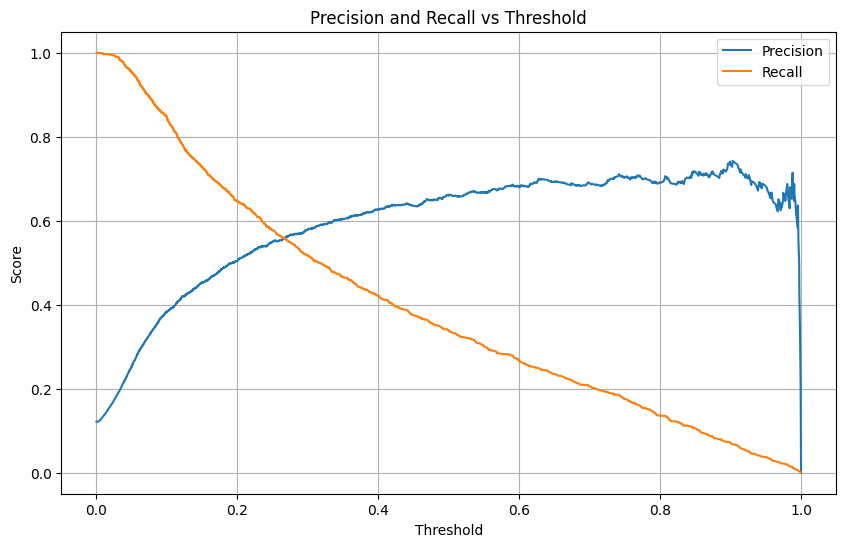

Intersection at threshold: 0.27
Precision and recall at intersection: 0.558


In [8]:
if 'y_val_pred' not in locals():
    print("Error: y_val_pred not defined. Run previous cell first.")
else:
    thresholds = np.arange(0.0, 1.01, 0.01)
    y_val_numeric = (y_val == 'yes').astype(int)

    precisions, recalls, thresholds = precision_recall_curve(y_val_numeric, y_val_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    intersection_idx = np.argmin(np.abs(precisions - recalls))
    intersection_threshold = thresholds[intersection_idx]
    intersection_score = (precisions[intersection_idx] + recalls[intersection_idx]) / 2

    print(f"Intersection at threshold: {intersection_threshold:.2f}")
    print(f"Precision and recall at intersection: {intersection_score:.3f}")


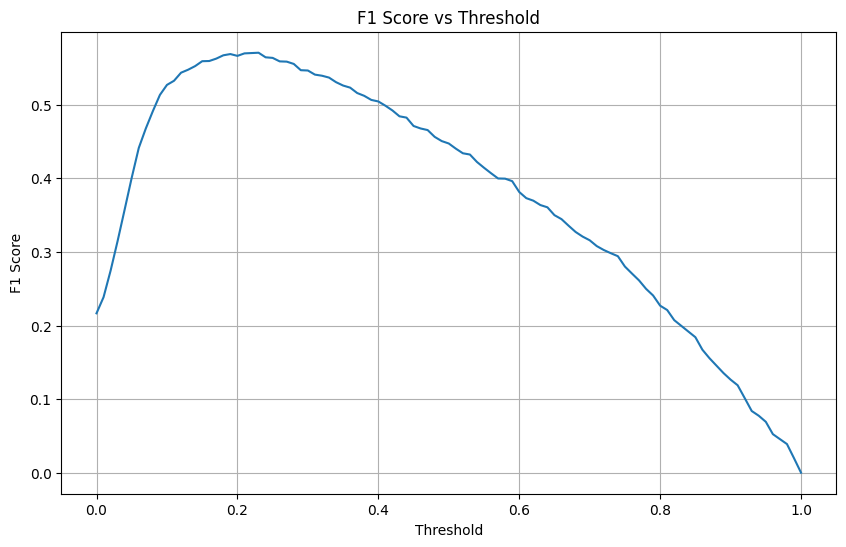

Maximum F1 score of 0.571 at threshold: 0.23


In [9]:
thresholds = np.arange(0.0, 1.01, 0.01)
y_val_numeric = (y_val == 'yes').astype(int)

f1_scores = [f1_score(y_val_numeric, (y_val_pred >= t).astype(int)) for t in thresholds]

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold, max_f1_score = thresholds[max_f1_idx], f1_scores[max_f1_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()

print(f"Maximum F1 score of {max_f1_score:.3f} at threshold: {max_f1_threshold:.2f}")


In [10]:

print("Shape of df_full_train:", df_full_train.shape)
print("\nFirst few rows of df_full_train:")
print(df_full_train.head())

Shape of df_full_train: (36168, 15)

First few rows of df_full_train:
       age          job  marital  education  balance housing   contact  day  \
22468   52   management  married   tertiary        0      no  cellular   22   
6896    50       admin.   single  secondary      330     yes   unknown   28   
28408   45  blue-collar  married    primary      300     yes  cellular   29   
8481    38   technician  married  secondary       27     yes   unknown    3   
28753   31     services   single  secondary      887      no  cellular   30   

      month  duration  campaign  pdays  previous poutcome   y  
22468   aug       232         2     -1         0  unknown  no  
6896    may        24         1     -1         0  unknown  no  
28408   jan       203         1    261         3  failure  no  
8481    jun       404         4     -1         0  unknown  no  
28753   jan       427         1     -1         0  unknown  no  


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_index, val_index in kf.split(df_full_train):
    df_train_fold, df_val_fold = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
    
    y_train_fold = (df_train_fold.pop('y') == 'yes').astype(int)
    y_val_fold = (df_val_fold.pop('y') == 'yes').astype(int)
    
    dv = DictVectorizer(sparse=False)
    df_train_fold = dv.fit_transform(df_train_fold.to_dict(orient='records'))
    df_val_fold = dv.transform(df_val_fold.to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(df_train_fold, y_train_fold)
    
    y_pred_fold = model.predict_proba(df_val_fold)[:, 1]
    auc_scores.append(roc_auc_score(y_val_fold, y_pred_fold))

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"Mean AUC: {mean_auc:.3f}")
print(f"Standard deviation of AUC: {std_auc:.3f}")


Mean AUC: 0.906
Standard deviation of AUC: 0.006


In [12]:
c_values = [0.000001, 0.001, 1]
results = []

for C in c_values:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores = []
    
    for train_index, val_index in kf.split(df_full_train):
        df_train_fold, df_val_fold = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
        
        y_train_fold = (df_train_fold.pop('y') == 'yes').astype(int)
        y_val_fold = (df_val_fold.pop('y') == 'yes').astype(int)
        
        dv = DictVectorizer(sparse=False)
        df_train_fold = dv.fit_transform(df_train_fold.to_dict(orient='records'))
        df_val_fold = dv.transform(df_val_fold.to_dict(orient='records'))
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(df_train_fold, y_train_fold)
        
        y_pred_fold = model.predict_proba(df_val_fold)[:, 1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred_fold))
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

best_c, best_mean_auc, best_std_auc = max(results, key=lambda x: x[1])

for c, mean_auc, std_auc in results:
    print(f"C={c}: Mean AUC = {mean_auc}, Std AUC = {std_auc}")

print(f"\nBest C value: {best_c}")
print(f"Best Mean AUC: {best_mean_auc}")
print(f"std AUC: {best_std_auc}")


C=1e-06: Mean AUC = 0.701, Std AUC = 0.009
C=0.001: Mean AUC = 0.861, Std AUC = 0.007
C=1: Mean AUC = 0.906, Std AUC = 0.006

Best C value: 1
Best Mean AUC: 0.906
std AUC: 0.006
